In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import niskine
import mplniw.sigp as sp
import mplniw.plot as pl
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/'

In [3]:
mooring=1
wind_work = xr.open_dataset(root_dir+'data/wind_work/ni_wind_work_niskine_m1.nc')
gridded = xr.open_dataset(root_dir+'data/gridded/M%s_gridded_simple_merge_gaps_filled.nc'%mooring)
filtered = xr.open_dataset('/Users/zcasparcohen/Documents/NISKINE/data/filtered_convolve.nc')

In [4]:
ds_filtered = sp.ni_bandpass_adcp(gridded)
ds_filt,wkb = sp.calc_ni_eke(ds_filtered)

In [5]:
ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
ds_filt['eke'] = 0.5*((ds_filt.u-ds_filt.u.mean())**2+(ds_filt.v-ds_filt.v.mean())**2)
ds_filt['bpu_wkb'] = ds_filt['bpu']*wkb
ds_filt['bpv_wkb'] = ds_filt['bpv']*wkb

In [6]:
fc = ut.coriolis(lat)*3600*24/2/np.pi

In [7]:
ds_filt['ni_UV'] = (ds_filt['bpu_wkb'] + 1j * ds_filt['bpv_wkb']).fillna(0.)
ds_filt['UV'] = (ds_filt['u'] + 1j * ds_filt['v']).fillna(0.)

### Global

In [13]:
Nb = 30*24*6
f,E = sp.wrap_spectra(ds_filt,'UV',Nb=Nb,**{'return_onesided':True})

(<matplotlib.patches.Rectangle at 0x2824bc090>,
 (<matplotlib.patches.ConnectionPatch at 0x28258e0d0>,
  <matplotlib.patches.ConnectionPatch at 0x2825d4950>))

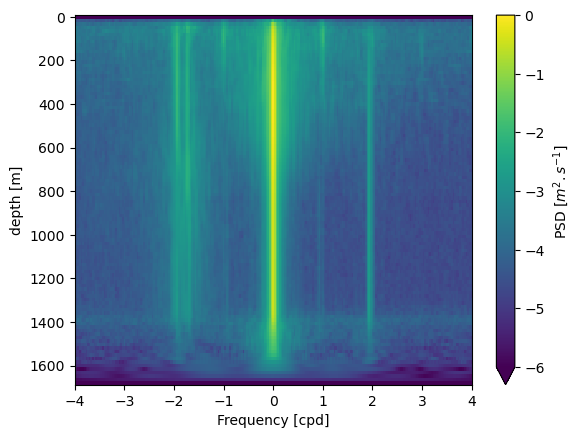

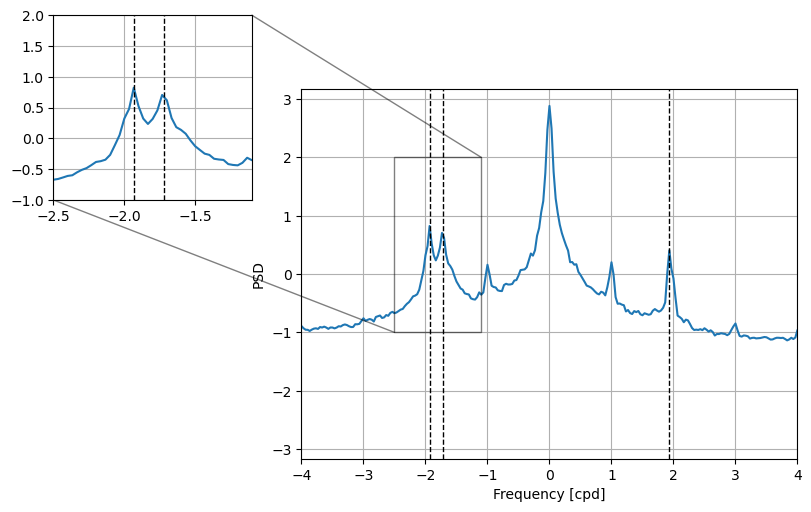

In [134]:
# Power spectra depending on depth
fig,ax = plt.subplots()
np.log10(E).plot(ax=ax,yincrease=False,xlim=(-4,4),vmax=0,vmin=-6)

# Integrated rotary spectra
fig,ax = plt.subplots()
np.log10(E.integrate(coord='z')).plot(ax=ax,xlim=(-4,4));
ax.set_ylabel('PSD');
for v in [-1.93,1.93,-fc]:
    ax.axvline(v,c='k',lw=1,ls='--')
ax.grid();
#fig,ax = plt.subplots()
#np.log10(_E).plot(ax=ax,yincrease=False,xlim=(-4,4),vmax=0,vmin=-6)

axins = ax.inset_axes([-0.5, 0.7, 0.4, 0.5])
np.log10(E.integrate('z')).plot(ax=axins)
axins.set_xlim((-2.5),(-1.1))
axins.set_ylim((-1),(2))
axins.set_ylabel('');axins.set_xlabel('');axins.grid();
axins.axvline(-1.93,c='k',ls='--',lw=1);axins.axvline(-fc,c='k',ls='--',lw=1);
ax.indicate_inset_zoom(axins,edgecolor='black')

### Seasonal: JFM - JJA

In [12]:
Nb = 30*24*6
f,E_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'UV',Nb=Nb)
f,E_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'UV',Nb=Nb)

Text(0.5, 1.0, 'Summer: JJA')

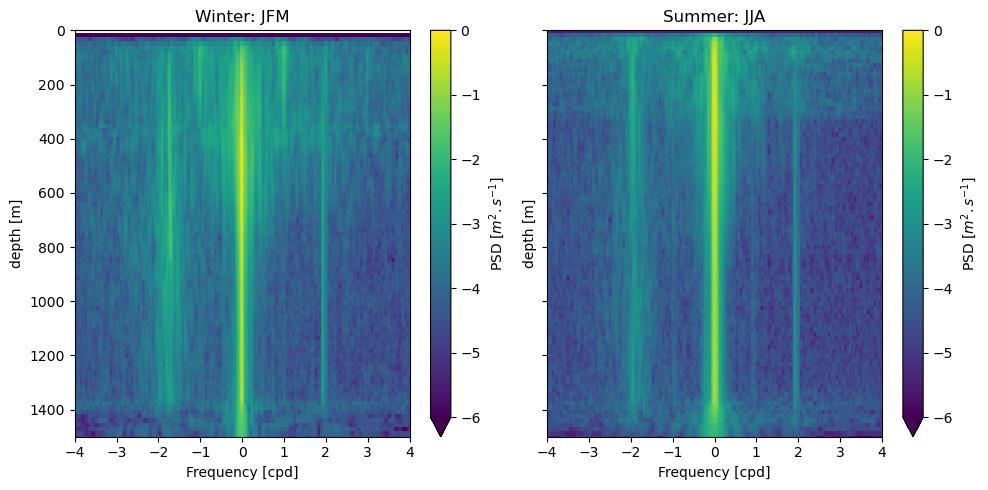

In [14]:

fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True,tight_layout=True)
np.log10(E_winter).plot(ax=ax[0],yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
ax[0].set_title('Winter: JFM')
np.log10(E_summer).plot(ax=ax[1],yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
ax[1].set_title('Summer: JJA')

#### Comments:

Winter: Near-inertial signal is dominant (compared to semidiurnal tide) and easily disctint from tidal signal from surface to $\sim$ 900m depth. From there downward the amplitudes of both motions are similar but the gap between frequencies is large enough that bandpass filtering extracts most of the NI signal (if the bandwidth is narrow enough).

Summer : Semi-diurnal tide is dominant at all depth. And vorticity mostly positive (cf draft paper), resulting in a frequency shift.
Both effects combined make almost impossible (using bandpass filtering) to separate near-inertial oscillations from tidal signal.



Conclusion, any event of high NI KE observed during summer is most likely highly contaminated by tidal signal. This is not a big problem as we actually don't observe any significantly high KE levels during this period of the year. It might become one however at other locations with similar latitudes.
In winter, NI signal at depth may be contaminated by semidiurnal tide, especially if tides or NIW (or both) are strongly non-stationary.

(<matplotlib.patches.Rectangle at 0x282278e50>,
 (<matplotlib.patches.ConnectionPatch at 0x28226bf10>,
  <matplotlib.patches.ConnectionPatch at 0x282267ad0>))

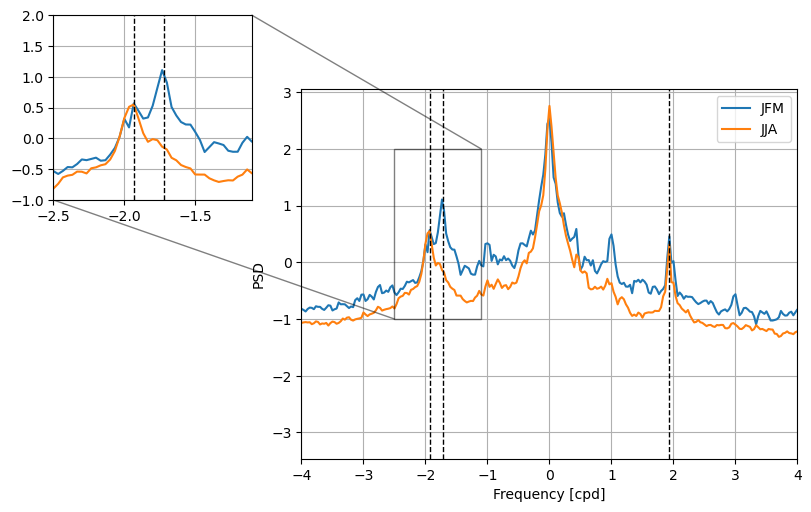

In [132]:
fig,ax = plt.subplots()
np.log10(E_winter.integrate('z')).plot(ax=ax,xlim=(-4,4),label='JFM')
np.log10(E_summer.integrate('z')).plot(ax=ax,xlim=(-4,4),label='JJA')
ax.legend();ax.set_ylabel('PSD')
for v in [-1.93,1.93,-fc]:
    ax.axvline(v,lw=1,ls='--',c='k')
ax.grid();
axins = ax.inset_axes([-0.5, 0.7, 0.4, 0.5])
np.log10(E_winter.integrate('z')).plot(ax=axins)
np.log10(E_summer.integrate('z')).plot(ax=axins)
axins.set_xlim((-2.5),(-1.1))
axins.set_ylim((-1),(2))
axins.set_ylabel('');axins.set_xlabel('');axins.grid();
axins.axvline(-1.93,c='k',ls='--',lw=1);axins.axvline(-fc,c='k',ls='--',lw=1);
ax.indicate_inset_zoom(axins,edgecolor='black')

#### Comments:
Winter: Near-inertial signal is dominant and easily disctint from tide.

Summer : Semi-diurnal tide is dominant. And vorticity mostly positive (cf draft paper), resulting in a frequency shift.
Both effects combinded make almost impossible (using bandpass filtering) to separate near-inertial oscillations from tidal signal.

Conclusion, any event of high NI KE observed during summer is most likely highly contaminated by tidal signal. This is not a big proble; since we actually don't observe any significantly high KE levels during this period of the year

### Wind events

In [22]:
# "a la main":
ti = ['2019-11-09T02:00:00.000000000','2020-01-03T01:00:00.000000000',
      '2020-02-13T02:00:00.000000000','2020-03-08T12:00:00.000000000']
tf = ['2019-11-22T09:00:00.000000000','2020-01-19T14:00:00.000000000',
      '2020-02-26T19:00:00.000000000','2020-03-25T04:00:00.000000000']
months = ['2029-11','2020-01','2020-02','2020-03']

In [89]:
spectra_month,spectra_event = {}, {}
for index in range(len(ti)):
    Nb = 30*24*6
    f,EJ = sp.wrap_spectra(ds_filt.sel(time=slice(ti[index][:8]+'01',ti[index][:5]+ti[index][5]+str(int(ti[index][6])+1)+'-01')),'UV',Nb=Nb)
    Nb = ds_filt['UV'].isel(z=1).sel(time=slice(ti[index],tf[index])).time.size
    f,EJevent = sp.wrap_spectra(ds_filt.sel(time=slice(ti[index],tf[index])),'UV',Nb=Nb)
    spectra_event[str(index)] = EJevent
    spectra_month[str(index)] = EJ

In [61]:
import matplotlib.gridspec as gridspec

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


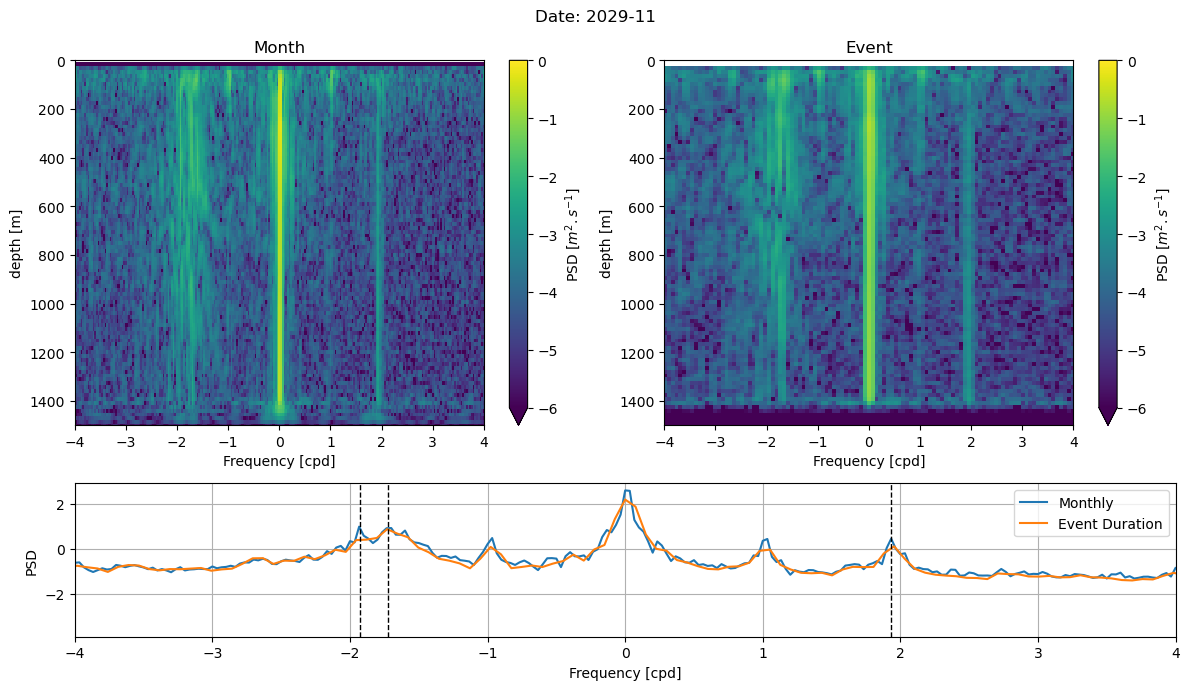

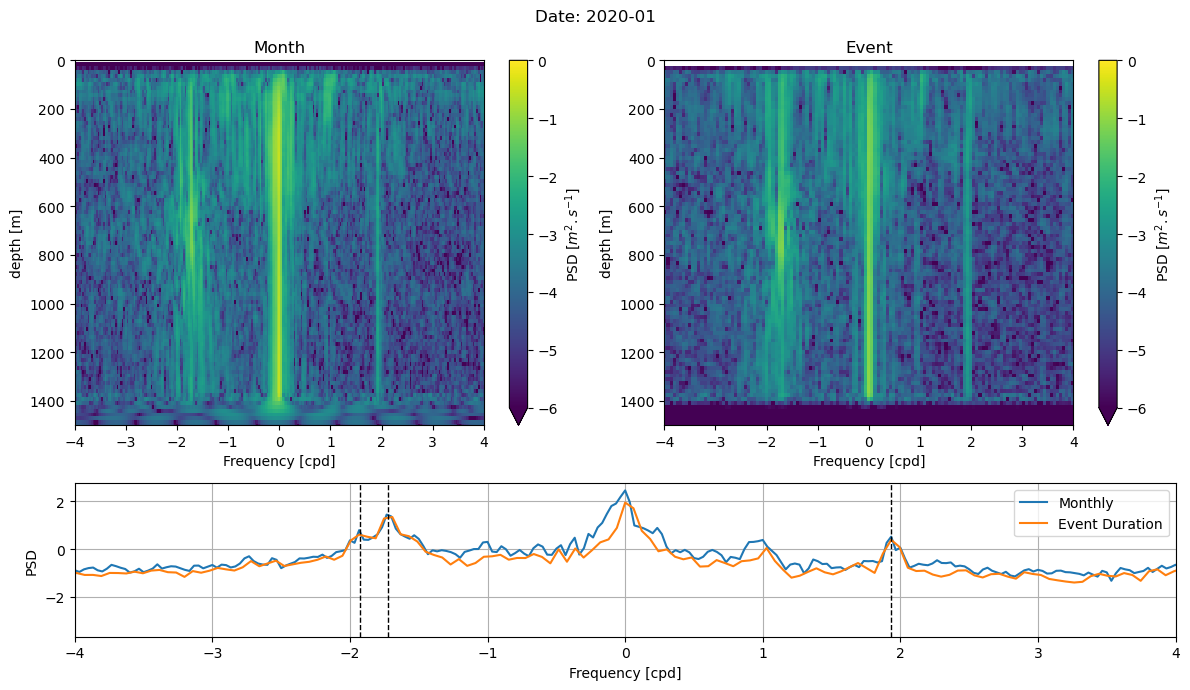

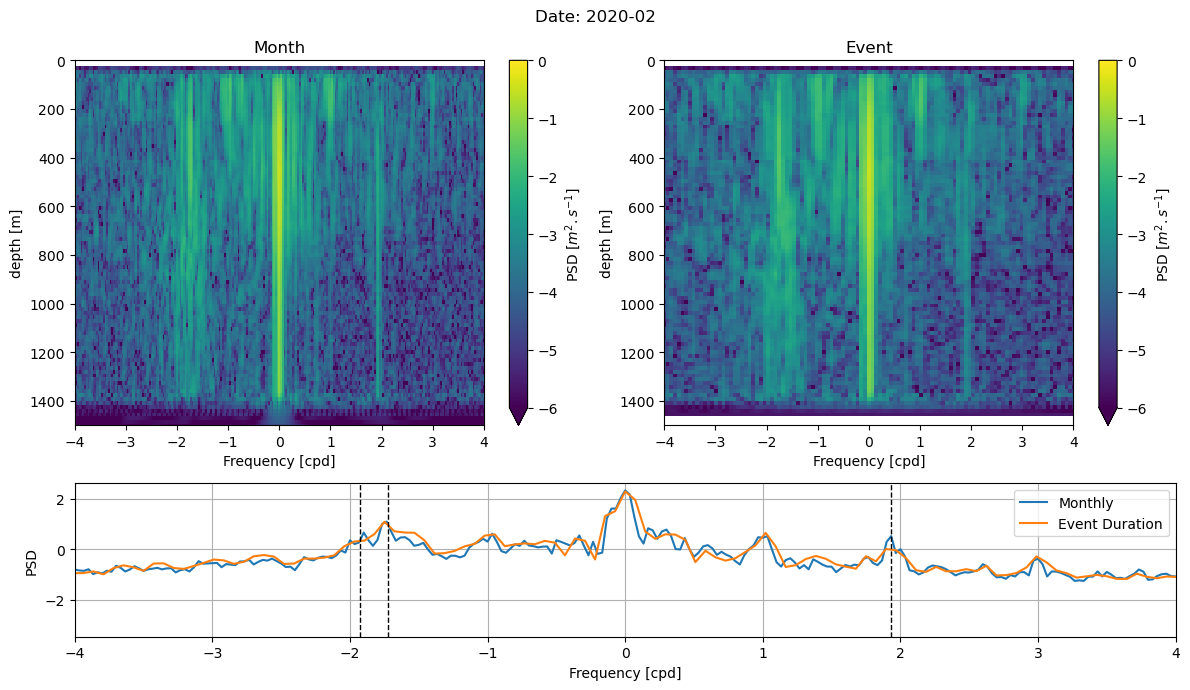

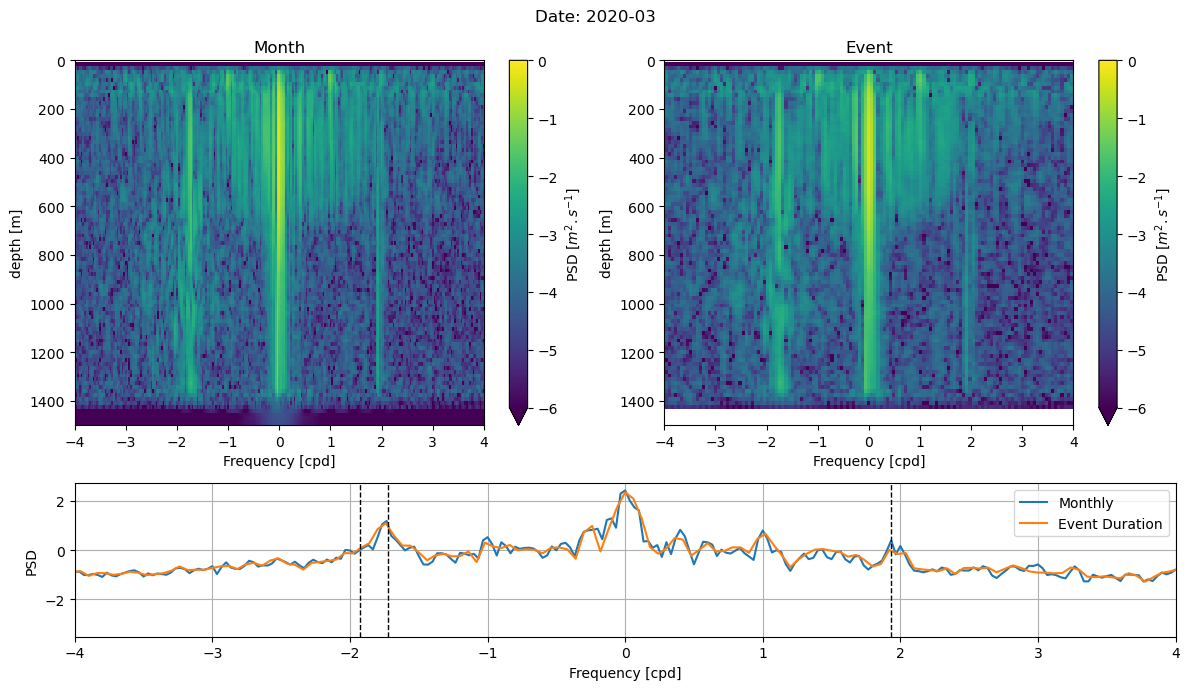

In [91]:
for index in range(len(ti)):
    _E = spectra_month[str(index)]
    _Eevent = spectra_event[str(index)]
    fig = plt.figure(tight_layout=True,figsize=(12,7))
    gs = gridspec.GridSpec(3,2)
    ax = fig.add_subplot(gs[:2,0])
    np.log10(_E).plot(ax=ax,yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
    ax.set_title('Month')
    ax = fig.add_subplot(gs[:2,1])
    np.log10(_Eevent).plot(ax=ax,yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
    ax.set_title('Event')
    
    ax = fig.add_subplot(gs[2,:])
    np.log10(_E.integrate('z')).plot(ax=ax,xlim=(-4,4),label='Monthly')
    np.log10(_Eevent.integrate('z')).plot(ax=ax,xlim=(-4,4),label='Event Duration')
    ax.legend();ax.set_ylabel('PSD')
    for v in [-1.93,1.93,-fc]:
        ax.axvline(v,lw=1,ls='--',c='k')
    ax.grid();
    fig.suptitle('Date: %s'%months[index])

#### 'Classic' PSD for u and v

In [19]:
ds_filt['u'] = ds_filt.u.fillna(0)
ds_filt['v'] = ds_filt.v.fillna(0)

In [28]:
Nb = 30*24*6
f,_Eu_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'u',Nb=Nb,**{'return_onesided':True})
f,_Eu_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'u',Nb=Nb,**{'return_onesided':True})

f,_Ev_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'v',Nb=Nb,**{'return_onesided':True})
f,_Ev_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'v',Nb=Nb,**{'return_onesided':True})

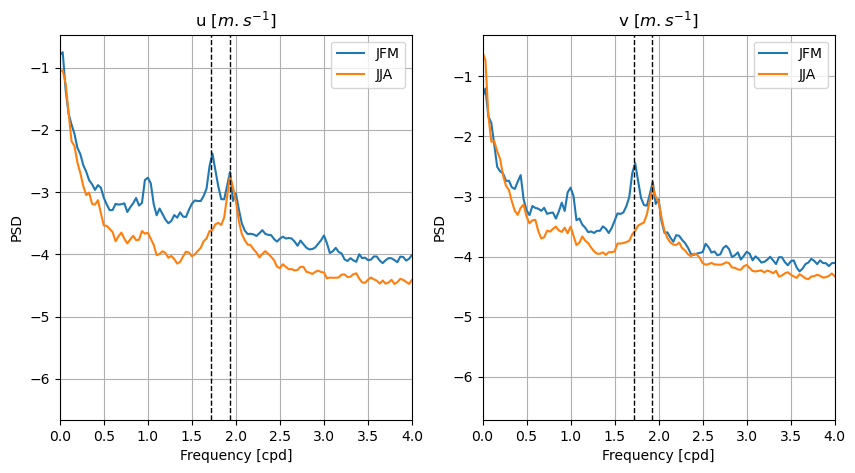

In [33]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(_Eu_winter.mean('z')).plot(ax=ax[0],xlim=(0,4),label='JFM')
np.log10(_Eu_summer.mean('z')).plot(ax=ax[0],xlim=(0,4),label='JJA')
ax[0].set_title(r'u [$m.s^{-1}$]')
np.log10(_Ev_winter.mean('z')).plot(ax=ax[1],xlim=(0,4),label='JFM')
np.log10(_Ev_summer.mean('z')).plot(ax=ax[1],xlim=(0,4),label='JJA')
ax[1].set_title(r'v [$m.s^{-1}$]')
for a in ax:
    a.legend();a.set_ylabel('PSD')
    for v in [1.93,fc]:
        a.axvline(v,lw=1,ls='--',c='k')
    a.grid();